### Climate Analysis and Exploration

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func, desc
from matplotlib.ticker import NullFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from flask import Flask, jsonify
import datetime as dt

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [5]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement

In [7]:
Station = Base.classes.station

In [8]:
session = Session(engine)

### Precipitation Analysis

In [48]:
# Precipitation Date List
prcp_date_list = session.query(Measurement.date).\
group_by(Measurement.date).\
order_by(desc(Measurement.date)).limit(365).all()
len(pd.Series(prcp_date_list).unique())

365

In [10]:
# Precipitation Values List
prcp_list = session.query(Measurement.prcp).\
group_by(Measurement.date).\
order_by(desc(Measurement.date)).limit(365).all()
len(prcp_list)

365

In [11]:
# Creating Pandas Dataframe
initial_prcp_df = pd.DataFrame(prcp_date_list).join(pd.DataFrame(prcp_list))
prcp_df = initial_prcp_df.set_index('date')
prcp_df.tail(10)

,prcp
date,
2016-09-02,0.03
2016-09-01,0.01
2016-08-31,2.46
2016-08-30,0.05
2016-08-29,0.90
2016-08-28,2.07
2016-08-27,0.12
2016-08-26,0.01
2016-08-25,0.11


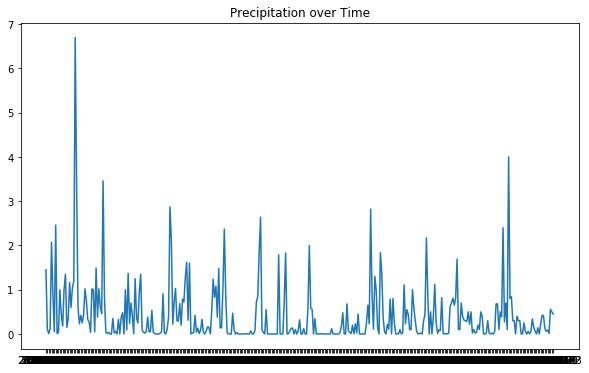

In [14]:
# Plotting Precipitation vs Date
dates = prcp_df.index
plt.figure(figsize=(10,6))
plt.title('Precipitation over Time')
plt.plot(dates, prcp_df['prcp'])

plt.show()

In [15]:
# Display Summary Statistics
prcp_df.describe()

,prcp
count,365.000000
mean,0.413753
std,0.691290
min,0.000000
25%,0.000000
50%,0.120000
75%,0.550000
max,6.700000


### Station Analysis

In [16]:
session.query(Station.station).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [17]:
station_freq = session.query(Measurement.station, func.count(Measurement.station)).\
   group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

In [18]:
stations = []
stat_freq = []

for z in range(len(station_freq)):
    (station, frequency) = station_freq[z]
    stations.append(station)
    stat_freq.append(frequency)

In [19]:
stations_df = pd.DataFrame(stations)
renamed_stations_df = stations_df.rename(columns={0 : 'stations'})
stat_freq_df = pd.DataFrame(stat_freq)
renamed_stat_freq = stat_freq_df.rename(columns={0 : 'frequency'})

In [20]:
station_freq_df = renamed_stations_df.join(renamed_stat_freq)
station_freq_df

,stations,frequency
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [21]:
max_station = station_freq_df['stations'].loc[station_freq_df['frequency'] == max(station_freq_df['frequency'])]

In [22]:
print(f'The station is {max_station}.')

The station is 0    USC00519281
Name: stations, dtype: object.


#### The most active station is USC00519281.

In [24]:
tobs_freq = session.query(Measurement.station, func.count(Measurement.tobs)).\
    filter(Measurement.date >= min(prcp_df.index)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [25]:
tobs_station = []
tobs_count_list = []

for tob in range(len(tobs_freq)):
    (station, tobs_count) = tobs_freq[tob]
    tobs_station.append(station)
    tobs_count_list.append(tobs_count)

In [26]:
tobs_df = (pd.DataFrame(tobs_station).rename(columns={0 : 'station'})).join((pd.DataFrame(tobs_count_list)).rename(columns={0 : 'count'}))

In [27]:
tobs_df

,station,count
0,USC00519397,358
1,USC00519281,351
2,USC00513117,342
3,USC00516128,327
4,USC00519523,313
5,USC00514830,264
6,USC00517948,60


Text(0.5,1,'Stations with the most tobs in the last 12 months')

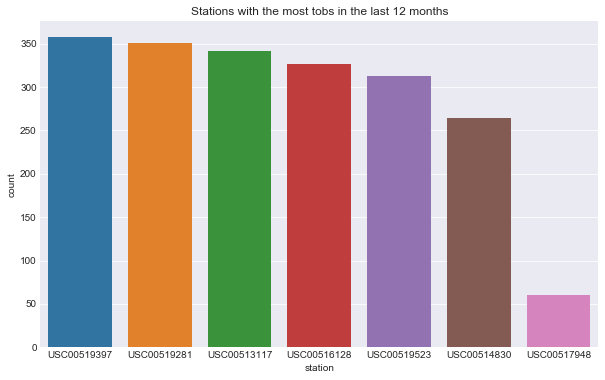

In [28]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
sns.barplot(x=tobs_df['station'], y=tobs_df['count'])
plt.title("Stations with the most tobs in the last 12 months")

### Temperature Analysis

In [29]:
start_date = '2011-01-01'
end_date = '2012-01-01'

In [30]:
calc_temps = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).order_by(Measurement.date.desc()).all()

In [31]:
calc_temps[0:10]

[('2012-01-01', 63.0, 68.42857142857143, 71.0),
 ('2011-12-31', 63.0, 66.42857142857143, 71.0),
 ('2011-12-30', 65.0, 69.71428571428571, 73.0),
 ('2011-12-29', 70.0, 72.66666666666667, 77.0),
 ('2011-12-28', 69.0, 71.0, 73.0),
 ('2011-12-27', 69.0, 71.57142857142857, 76.0),
 ('2011-12-26', 69.0, 71.83333333333333, 75.0),
 ('2011-12-25', 69.0, 72.83333333333333, 75.0),
 ('2011-12-24', 65.0, 69.16666666666667, 71.0),
 ('2011-12-23', 69.0, 71.0, 73.0)]

In [32]:
temp_dates = []
min_temp_list = []
avg_temp_list = []
max_temp_list = []

for temp in range(len(calc_temps)):
    (date, min_temp, avg_temp, max_temp) = calc_temps[temp]
    temp_dates.append(date)
    min_temp_list.append(min_temp)
    avg_temp_list.append(avg_temp)
    max_temp_list.append(max_temp)

In [33]:
calc_temps_raw_dict = {
    "date" : temp_dates,
    "min_temp" : min_temp_list,
    "avg_temp" : avg_temp_list,
    "max_temp" : max_temp_list
}

In [34]:
calc_temps_df = pd.DataFrame(calc_temps_raw_dict)
calc_temps_df.head()

,avg_temp,date,max_temp,min_temp
0,68.428571,2012-01-01,71.0,63.0
1,66.428571,2011-12-31,71.0,63.0
2,69.714286,2011-12-30,73.0,65.0
3,72.666667,2011-12-29,77.0,70.0
4,71.000000,2011-12-28,73.0,69.0


Text(0.5,1,'Trip Avg Temp')

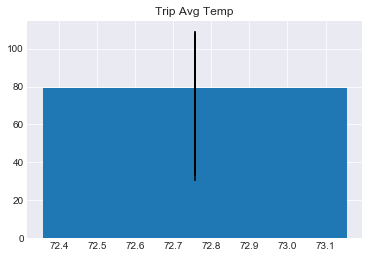

In [35]:
sns.set_style("darkgrid")
x = calc_temps_df['avg_temp'].mean()
y = calc_temps_df['avg_temp']
fig, ax = plt.subplots()
error = max(calc_temps_df['max_temp']) - min(calc_temps_df['min_temp'])
ax.bar(x, y, xerr=None, yerr=error)
plt.title("Trip Avg Temp")

### Climate App

In [ ]:
app = Flask(__name__)

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start_date(YYYY-MM-DD)<br/>"
        f"/api/v1.0/start_date/end_date(YYYY-MM-DD)"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return a list of the dates and temperature observations from the last year."""
    # Query results
    prcp_date_list = session.query(Measurement.date).\
                     group_by(Measurement.date).\
                     order_by(desc(Measurement.date)).limit(365).all()

    prcp_list = session.query(Measurement.prcp).\
                group_by(Measurement.date).\
                order_by(desc(Measurement.date)).limit(365).all()

    # Create a dictionary
    all_prcps = {"date" : prcp_date_list, "prcp" : prcp_list}
    
    return jsonify(all_prcps)

@app.route("/api/v1.0/stations")
def stations():
    """Returns a list of stations from the dataset."""
    # Query results
    results = session.query(Station.station).all()

    all_stations = list(np.ravel(results))

    return jsonify(all_stations)

@app.route("/api/v1.0/tobs")
def tobs():
    """Returns list of Temperature Observations (tobs) for the previous year."""
    # Query results
    results = session.query(Measurement.date, Measurement.tobs).\
           filter(Measurement.date >= '2016-08-24').\
           filter(Measurement.date <= '2017-08-23').\
           group_by(Measurement.date).order_by(Measurement.date.desc()).all()

    # Create a dictionary
    tobs_date_list = []
    tobs_list = []
    
    for tob in range(len(results)):
        (tobs_date, tobs) = results[tob]
        tobs_date_list.append(tobs_date)
        tobs_list.append(tobs)

    tobs_dict = {"date" : tobs_date_list, "tobs" : tobs_list}

    return jsonify(tobs_dict)

@app.route("/api/v1.0/<start>")
def start_date(start):
    """Returns a json list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range."""
    # Query results
    results = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start).\
           group_by(Measurement.date).order_by(Measurement.date.desc()).all()

    temp_dates = []
    min_temp_list = []
    avg_temp_list = []
    max_temp_list = []

    for temp in range(len(results)):
        (date, min_temp, avg_temp, max_temp) = results[temp]
        temp_dates.append(date)
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

    start_date_raw_dict = {
    "date" : temp_dates,
    "min_temp" : min_temp_list,
    "avg_temp" : avg_temp_list,
    "max_temp" : max_temp_list
    }

    return jsonify(start_date_raw_dict)

@app.route("/api/v1.0/<start>/<end>")
def dates(start, end):
    """Returns a json list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range."""
    # Query results
    results = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start).\
           filter(Measurement.date <= end).\
           group_by(Measurement.date).order_by(Measurement.date.desc()).all()

    temp_dates = []
    min_temp_list = []
    avg_temp_list = []
    max_temp_list = []

    for temp in range(len(results)):
        (date, min_temp, avg_temp, max_temp) = results[temp]
        temp_dates.append(date)
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

    dates_raw_dict = {
    "date" : temp_dates,
    "min_temp" : min_temp_list,
    "avg_temp" : avg_temp_list,
    "max_temp" : max_temp_list
    }

    return jsonify(dates_raw_dict)

if __name__ == "__main__":
    app.run(debug=True)
